In [1]:
import sys
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from pathlib import Path
sys.executable

'C:\\Users\\Os\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'

Demonstration of each model

In [7]:
from gmm.base_models.gbm import GeometricBrownianMotion
from gmm.models.gbm_gmm import GBM_GMM

In [20]:
mu_true = 0.05
sigma_true = 0.20
gbm_true = GeometricBrownianMotion(T=1, N=252, S0=1.0, mu=mu_true, sigma=sigma_true)
S = gbm_true.simulate()
gbm_naive = GeometricBrownianMotion(T=1, N=252, S0=1.0,mu=0.02, sigma=0.10)
S_naive = gbm_naive.simulate()
print('initial mean :', mu_true)
print('initial volatility :', sigma_true)

initial mean : 0.05
initial volatility : 0.2


In [24]:
gmm = GBM_GMM(dt=1/252, verbose=True)
res = gmm.fit(pd.Series(np.ndarray.flatten(S)))
mu, sigma = res.params_
print(mu, sigma)
gbm_gmm = GeometricBrownianMotion(T=1, N=252, S0=1.0,mu=mu, sigma=sigma)
S_gmm = gbm_gmm.simulate()

GBM GMM calibration complete
mu    = 262.349637
sigma = -2.380267
J-stat= 1.043245e-09
262.34963729763246 -2.3802665361373228


In [25]:
data_path = Path('gmm/datas/global_equity_ticker.csv')
df = pd.read_csv(data_path)
df.head

<bound method NDFrame.head of                  ID        DATE CURRENCY   PX_LAST
0      MEXBOL Index  2021-01-25      MXN  45126.52
1      MEXBOL Index  2021-01-26      MXN  45053.56
2      MEXBOL Index  2021-01-27      MXN  44262.01
3      MEXBOL Index  2021-01-28      MXN  44280.73
4      MEXBOL Index  2021-01-29      MXN  42985.73
...             ...         ...      ...       ...
36535     SMI Index  2026-01-21      CHF  13156.81
36536     SMI Index  2026-01-22      CHF  13228.40
36537     SMI Index  2026-01-23      CHF  13147.13
36538     SMI Index  2026-01-24      CHF  13147.13
36539     SMI Index  2026-01-25      CHF  13147.13

[36540 rows x 4 columns]>

Aggregated Equity Data as an empirical toy test

In [ ]:
df['Date'] = pd.to_datetime(df["DATE"])
df = df.sort_values("DATE")
px = df.set_index("DATE")["PX_LAST"].astype(float)
px.plot(title='Global equity index')

DATE
2021-01-27    0.718331
2021-01-28   -0.257319
2021-01-28    0.987298
2021-01-28    0.275411
2021-01-28    1.431424
                ...   
2026-01-25   -0.632851
2026-01-25   -1.715418
2026-01-25    1.187280
2026-01-25   -0.580149
2026-01-25   -0.208908
Name: PX_LAST, Length: 36481, dtype: float64


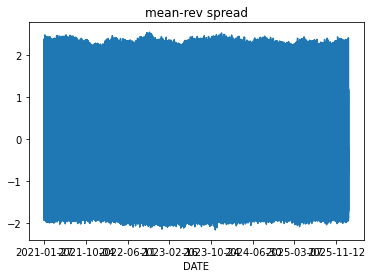

In [6]:
#log values
log_px = np.log(px)
spread = log_px - log_px.rolling(60).mean()
spread = spread.dropna()
spread.plot(title='mean-rev spread')
print(spread)

In [7]:
#parameters
dt = 1/252
x = spread.values
print(x)

[ 0.71833056 -0.25731944  0.98729813 ...  1.18728016 -0.58014905
 -0.20890821]


In [8]:
from gmm.base_models.general_ou import OU
from gmm.models.ou_gmm import OU_GMM

In [9]:
ou_gmm = OU_GMM(dt=dt, verbose=True)
ou_gmm.fit(x)


OU GMM calibration complete
kappa = 263.750828
theta = 0.000342
sigma = 37.093790
J-stat = 8.583330e-15


OU_GMM(verbose=True)

In [20]:
x_t = x[:-1]
x_tp1 = x[1:]
print(x_tp1)

[-0.25731944  0.98729813  0.2754109  ...  1.18728016 -0.58014905
 -0.20890821]


In [21]:
kappa_gmm, theta_gmm, sigma_gmm = ou_gmm.params_
print(kappa_gmm, theta_gmm, sigma_gmm)

263.7508281799459 0.0003419111573006652 37.09379002011565


In [22]:
x0 = spread.iloc[-1]
ou_gmm_sim = OU(x0, kappa_gmm, theta=theta_gmm, sigma=sigma_gmm)

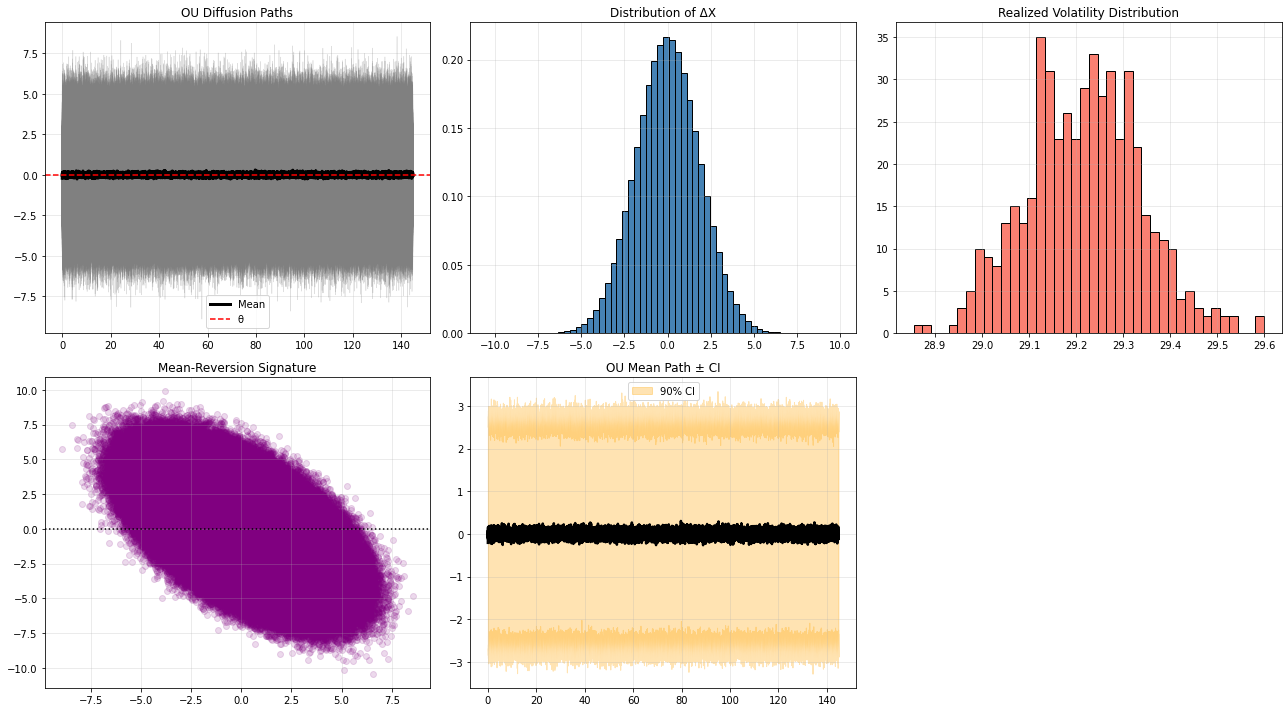

In [23]:
ou_gmm_sim.plot_diagnostics(T=len(spread), paths=500, seed=42)